## Creating a somewhat realistic sample information

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import time

# Creating a somewhat realistic sample information

# User-specific information
distance_unit = 'Kilometer'
route_length = 42 # the length of the route back to the starting point
minimum_fare = 13 # the fare passengers pay for the first minimum_distance kilometers
minimum_distance = 4 # distances longer than this require additional payment
additional_charge_per_km = 1.50 # the fare passengers pay for each succeeding kilometer

# Number of passengers for the day
n = 16000

# We are assuming that the number of passengers is dominated by commuting workers and students going to and from work and school respectively
# Therefore, the boarding time distribution is bimodal centered around 0700 and 1700
mu_time, sigma_time = 7, 3.75
mu2_time, sigma2_time = 17, 4.01
normal_time = np.random.normal(mu_time, sigma_time, n // 2)
normal2_time = np.random.normal(mu2_time, sigma2_time, n // 2)

# We are assuming that most passengers come from densely populated areas, and the route starting and midway segments usually are
# Therefore, the boarding place distribution is bimodal centered around 1 and route_length / 2
mu_place, sigma_place = 1, 3.87
mu2_place, sigma2_place = route_length / 2, 4.31
normal_place = np.random.normal(mu_place, sigma_place, n // 2)
normal2_place = np.random.normal(mu2_place, sigma2_place, n // 2)

# Removing invalid values (Time is only between 0000 and 2400)
for i in range(len(normal_time)):
    if normal_time[i] < 0 or normal_time[i] > 24:
        normal_time[i] = mu_time

for i in range(len(normal2_time)):
    if normal2_time[i] < 0 or normal2_time[i] > 24:
        normal2_time[i] = mu2_time

# Removing invalid values (Place is only between 0 and 42)
for i in range(len(normal_place)):
    if normal_place[i] < 0:
        normal_place[i] += 2 * (mu_place - normal_place[i])
    if normal_place[i] > route_length:
        normal_place[i] -= 2 * (normal_place[i] - mu_place)

for i in range(len(normal2_place)):
    if normal2_place[i] < 0:
        normal2_place[i] += 2 * (mu2_place - normal2_place[i])
    if normal2_place[i] > route_length:
        normal2_place[i] -= 2 * (normal2_place[i] - mu2_place)

bimodal_time = np.concatenate([normal_time, normal2_time])
bimodal_place = np.concatenate([normal_place, normal2_place])

# Turning the random numbers into random time objects and adding them to a DataFrame
info_dict = {'boarding_time': [], 'boarding_place': [], 'boarding_payment': []}

for i in bimodal_time:
    hour = int(i)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    info_dict['boarding_time'].append(time(hour, minute, second))

for i in bimodal_place:
    place = int(i)
    info_dict['boarding_place'].append(place)
    travel_distance = random.randint(0, route_length - place)
    if travel_distance <= minimum_distance:
        info_dict['boarding_payment'].append(minimum_fare)
    else:
        info_dict['boarding_payment'].append(minimum_fare + additional_charge_per_km * (travel_distance - minimum_distance))


df = pd.DataFrame(info_dict)


In [3]:
# A typical information sheet contains when passengers board, where passengers board, and how much passengers paid
df

,boarding_time,boarding_place,boarding_payment
0,12:24:14,0,13.0
1,13:52:16,4,37.0
2,08:25:45,0,61.0
3,05:02:48,3,22.0
4,07:24:57,3,32.5
...,...,...,...
15995,09:32:23,17,23.5
15996,15:07:45,19,23.5
15997,21:34:38,17,13.0
15998,22:57:01,13,43.0


In [4]:
# Cleaning up the data by sorting by boarding_time
df = df.sort_values('boarding_time')
df = df.reset_index()
df = df.drop('index', axis = 1)

# We do not need the exact time a passenger boards, just the hours
df['boarding_hour'] = df['boarding_time'].apply(lambda x: x.hour)

# Calculate how many passengers we get per kilometer-hour
passenger_distribution = df.pivot_table(index="boarding_hour", columns="boarding_place", aggfunc = 'size', fill_value=0)
passenger_distribution

boarding_place,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,36,37
boarding_hour,,,,,,,,,,,,,,,,,,,,,
0,16,12,29,28,28,25,13,10,9,3,...,0,0,0,0,0,0,0,0,0,0
1,32,40,54,40,48,34,22,12,10,6,...,0,0,0,0,0,0,0,0,0,0
2,53,45,86,70,63,42,30,25,10,6,...,0,0,0,0,0,0,0,0,0,0
3,58,64,123,97,82,47,41,25,18,6,...,1,0,1,0,0,0,0,0,0,0
4,67,84,134,119,94,76,53,24,18,6,...,0,0,0,0,0,0,0,0,0,0
5,86,84,170,123,119,80,59,47,25,9,...,1,1,0,0,0,0,0,0,0,0
6,82,90,175,130,113,91,67,33,27,12,...,2,0,0,0,0,0,0,0,0,0
7,131,115,228,187,125,111,89,47,30,24,...,3,2,0,0,0,0,0,0,0,0
8,69,81,163,138,98,79,52,43,20,18,...,3,4,0,0,0,0,0,0,0,0


In [5]:
# Calculate how much we earn per segment of kilometer per hour
income_distribution = df.pivot_table(index="boarding_hour", columns="boarding_place", values="boarding_payment", aggfunc = 'sum', fill_value=0)
income_distribution

boarding_place,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,36,37
boarding_hour,,,,,,,,,,,,,,,,,,,,,
0,631.0,546.0,1103.0,1043.5,1058.5,758.5,457.0,407.5,243.0,117.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1257.5,1514.5,2266.5,1484.5,1897.5,1193.5,721.0,345.0,287.5,195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2144.0,1770.0,2967.5,2576.5,2194.5,1470.0,1047.0,881.5,302.5,216.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,2468.5,2351.5,4998.0,3518.5,2780.5,1689.5,1538.0,857.5,543.0,186.0,...,17.5,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0,0
4,2429.5,3001.5,5196.5,4404.5,3668.5,2773.0,1857.5,825.0,675.0,226.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
5,3087.5,3318.0,6725.0,4359.0,4401.5,2784.5,2027.0,1536.5,884.5,348.0,...,23.5,14.5,0.0,0.0,0.0,0.0,0.0,0.0,0,0
6,3272.5,3385.5,6149.5,4877.5,4128.5,3133.0,2303.5,1053.0,918.0,303.0,...,39.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7,5214.5,4483.0,8662.5,6394.0,4250.0,3553.5,3299.0,1415.0,981.0,756.0,...,72.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
8,2748.0,3072.0,6151.0,4747.5,3648.5,2987.5,1907.5,1417.0,576.5,562.5,...,52.5,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


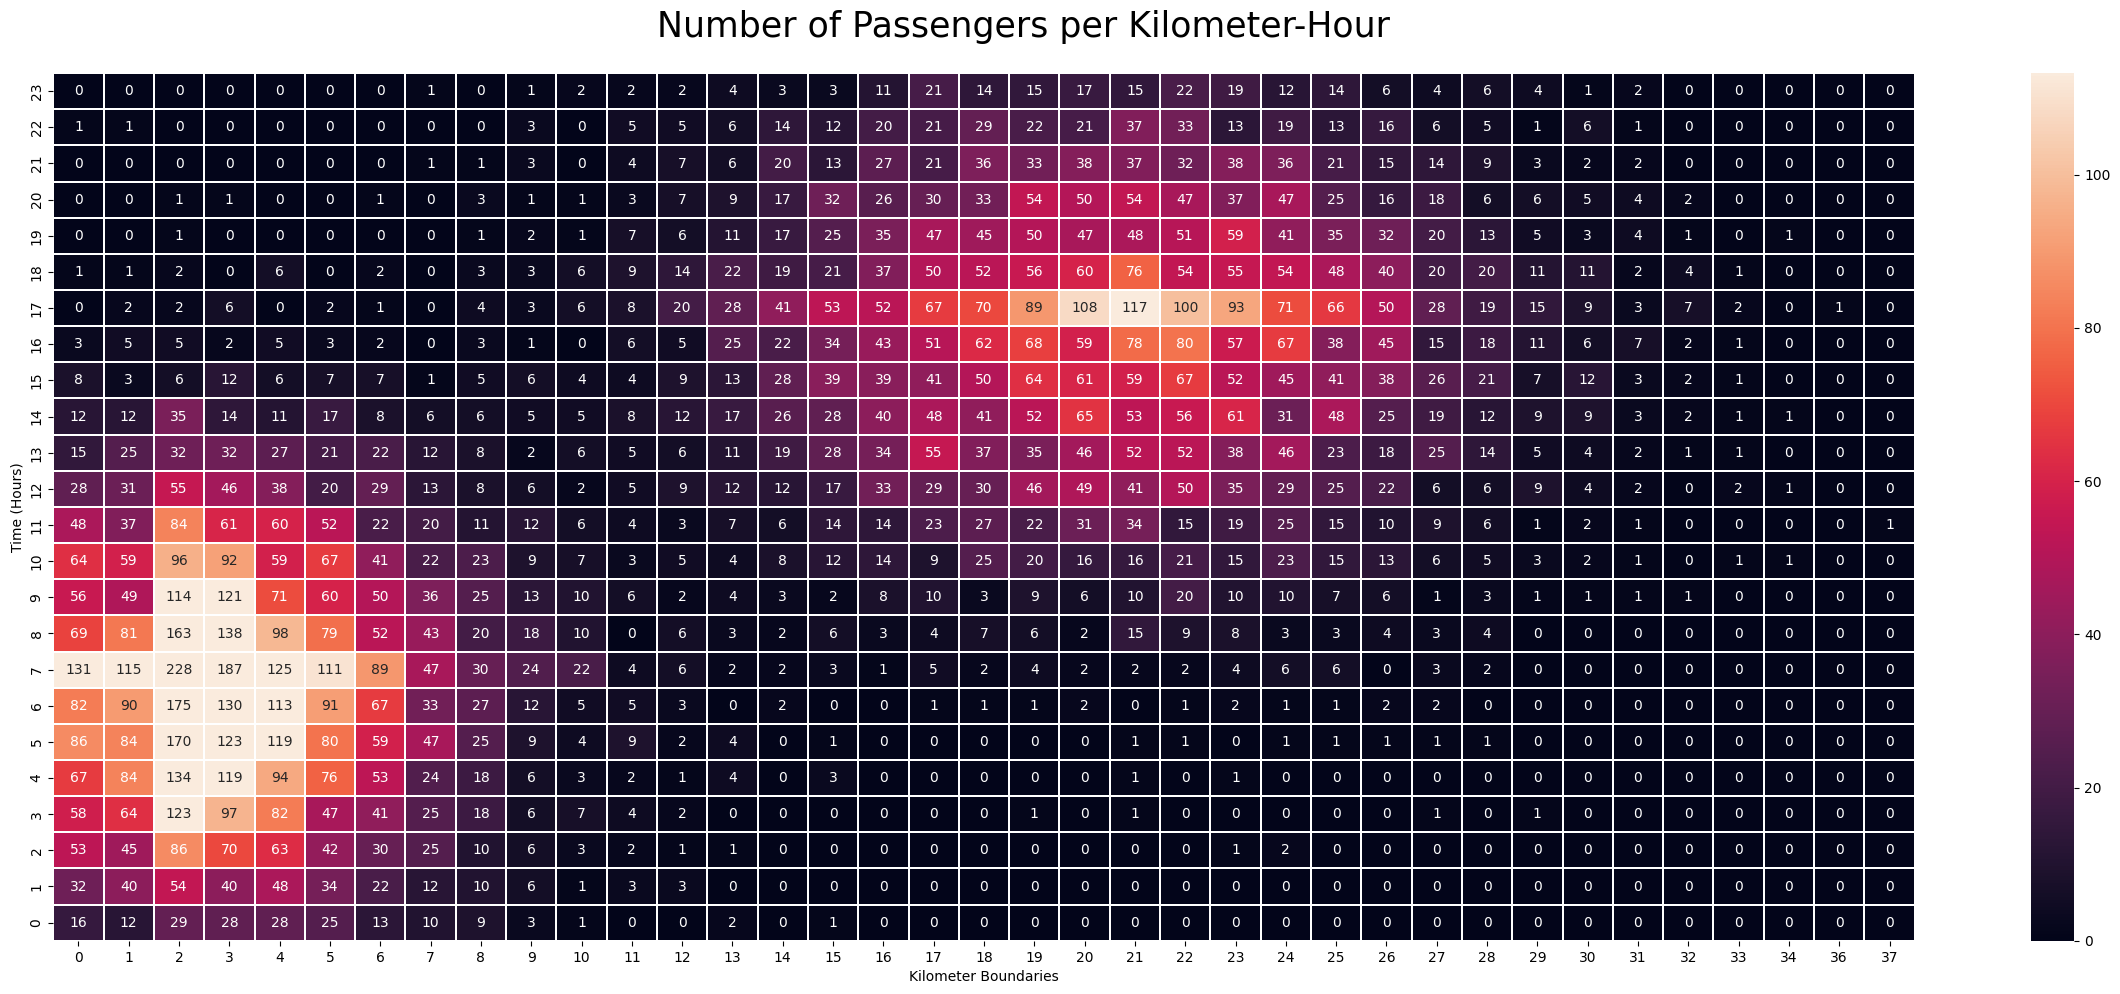

In [6]:
# Visualizing the passenger_distribution
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(passenger_distribution, annot = True, fmt = '1.0f', linewidths = 0.1, ax = ax, robust = True)
plt.xlabel(f'{distance_unit} Boundaries')
plt.ylabel('Time (Hours)')
plt.text(12, 25, f'Number of Passengers per {distance_unit}-Hour', fontsize = 25)
ax.invert_yaxis()
fig.tight_layout()

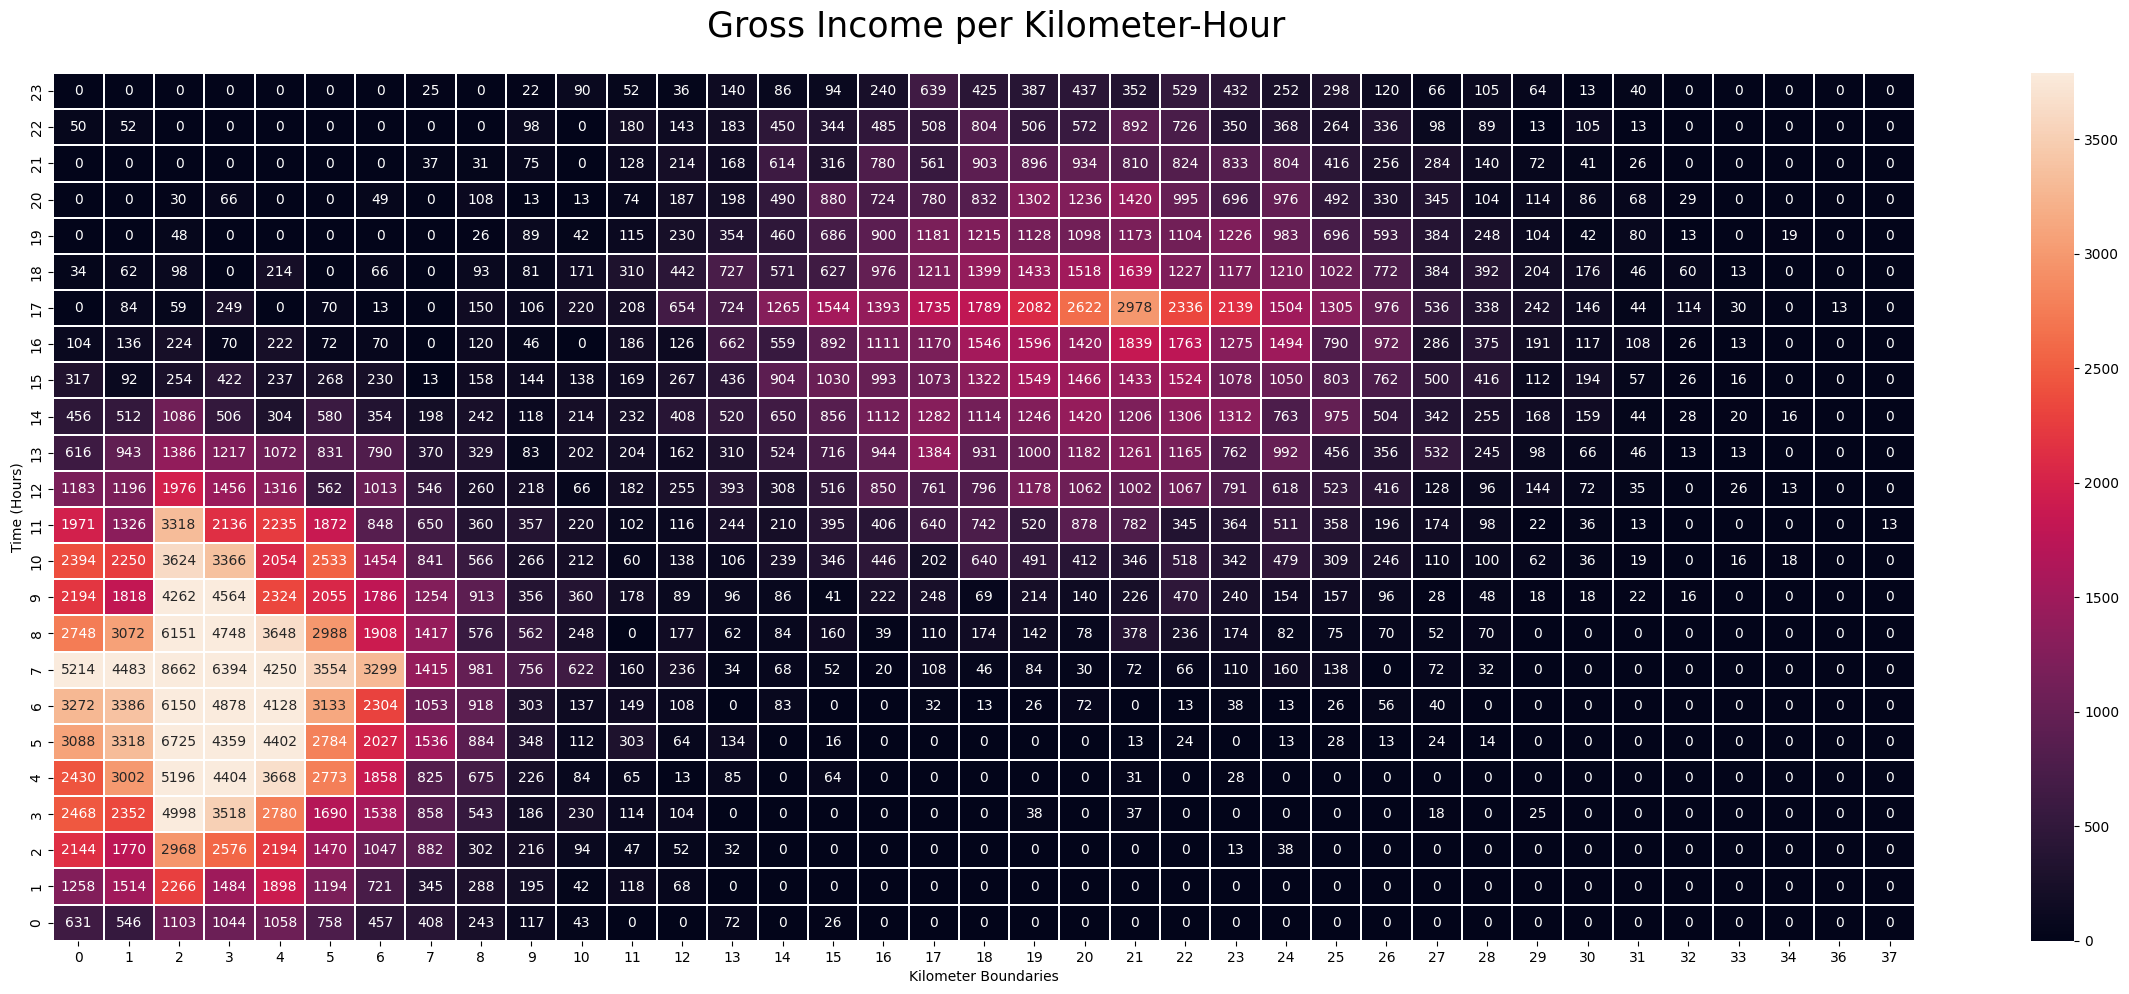

In [7]:
# Visualizing the income_distribution
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(income_distribution, annot = True, fmt = '1.0f', linewidths = 0.1, ax = ax, robust = True)
plt.xlabel(f'{distance_unit} Boundaries')
plt.ylabel('Time (Hours)')
plt.text(13, 25, f'Gross Income per {distance_unit}-Hour', fontsize = 25)
ax.invert_yaxis()
fig.tight_layout()

In [8]:
import math

# Calculating the minimum number of public utility vehicles needed to satisfy the demand by the hour

vehicle_capacity = 20 # Max capacity of a standard public utility vehicle

passenger_per_hour = passenger_distribution.T
passenger_per_hour.loc['Total Passengers'] = passenger_per_hour.sum()
minimum_vehicles = passenger_per_hour.loc['Total Passengers'].apply(lambda x: math.ceil(x / vehicle_capacity))
minimum_vehicles = minimum_vehicles.to_frame()
minimum_vehicles = minimum_vehicles.rename(columns = {'Total Passengers': 'Minimum Vehicles'})
minimum_vehicles

,Minimum Vehicles
boarding_hour,
0,9
1,16
2,22
3,29
4,35
5,42
6,43
7,59
8,43


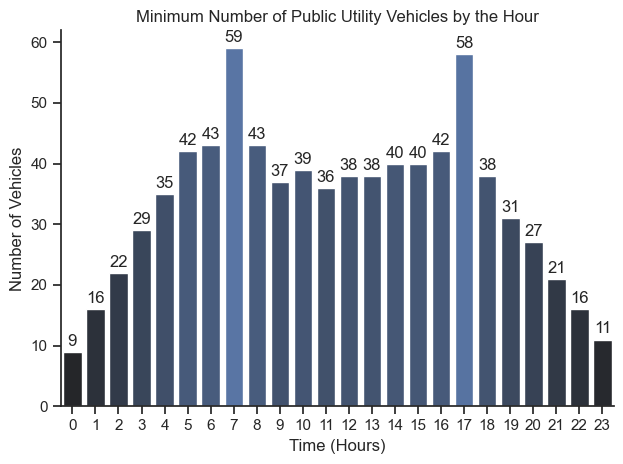

In [9]:
# Visualizing the minimum_vehicles
sns.set_theme(style = 'ticks')
sns.barplot(data = minimum_vehicles, x = minimum_vehicles.index, y = 'Minimum Vehicles', hue = 'Minimum Vehicles', palette = 'dark:b', legend = False)
sns.despine()
plt.xlabel('Time (Hours)')
plt.ylabel('Number of Vehicles')
plt.title('Minimum Number of Public Utility Vehicles by the Hour')

for i, value in enumerate(minimum_vehicles['Minimum Vehicles'].values.tolist()):
    plt.text(i, value + 1, value, ha = 'center')

plt.tight_layout()